# Decision Trees and Random Forest for Classification

- [Import Carseats Data](#Import-Carseats-Data)
- [Create Classification Tree](#Create-Classification-Tree)
- [Compute Training Error Rate](#Compute-Training-Error-Rate)
- [Random-Forests](#Random-Forests)

In [2]:
import numpy as np
import pandas as pd
# import graphviz

import sklearn
##from sklearn.tree import tree, export_graphviz
from sklearn import tree ##, export_graphviz
##from sklearn.tree import plot_tree 
from sklearn.tree import plot_tree, export_text

from sklearn.metrics import confusion_matrix
###from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.display import Image, display
%matplotlib inline
plt.style.use('ggplot')

## Import Carseats Data

In [3]:
# read in csv of data
df = pd.read_csv('Carseats.csv')  ##, index_col=0)
print(df.columns)

# create a new column called High, a boolean for if sales > 8
df['High'] = df.Sales > 8
df = pd.get_dummies(df, columns=['ShelveLoc', 'Urban', 'US'])
# drop the unnecessary columns -- remember the number of dummies is always one less than the number of levels

df = df.drop(['ShelveLoc_Bad', 'Urban_No', 'US_No'],axis=1)
#df.head(3)
df.info()

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales             400 non-null    float64
 1   CompPrice         400 non-null    int64  
 2   Income            400 non-null    int64  
 3   Advertising       400 non-null    int64  
 4   Population        400 non-null    int64  
 5   Price             400 non-null    int64  
 6   Age               400 non-null    int64  
 7   Education         400 non-null    int64  
 8   High              400 non-null    bool   
 9   ShelveLoc_Good    400 non-null    bool   
 10  ShelveLoc_Medium  400 non-null    bool   
 11  Urban_Yes         400 non-null    bool   
 12  US_Yes            400 non-null    bool   
dtypes: bool(5), float64(1), int64(

## Create Classification Tree

In [5]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)

# get the predictors
predictors = df.columns.tolist()
predictors.remove('Sales')
predictors.remove('High')

X = df[predictors].values

# get the response
y = df.High.values.reshape(-1,1)

# Build classification tree
tree_est = clf.fit(X, y)

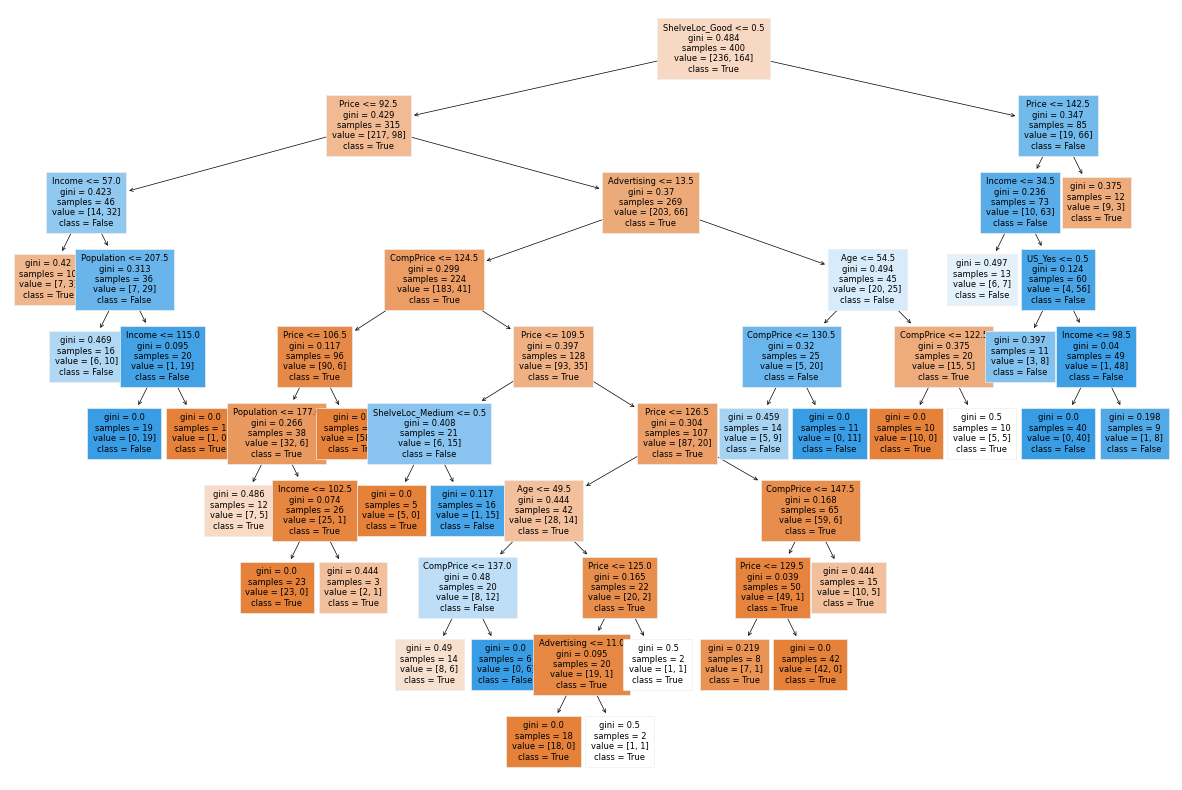

In [6]:
# plot tree
plt.figure(figsize=(15,10))  # set plot size (denoted in inches)
plot_tree(tree_est, feature_names=predictors,
          class_names=['True', 'False'],
          filled=True,
          fontsize=6);
#plt.show()

# save plot
plt.savefig('tree_high_dpi', dpi=100)

So we see that the initial splitting occurs with ShelveLoc and Price predictors. We can get the variable importance factor (the average Gini Index) for a predictor from sklearn.

In [7]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
Price,0.303185
ShelveLoc_Good,0.228331
CompPrice,0.109957
Age,0.095710
Advertising,0.088996
Income,0.078786
ShelveLoc_Medium,0.052739
Population,0.033288
US_Yes,0.009009
Education,0.000000


## Compute Training Error Rate

In [8]:
# Lets also get the training error rate of the tree model
cmatrix = confusion_matrix(y_true = y, y_pred=tree_est.predict(X), labels=[True, False])
print(cmatrix)

[[133  31]
 [ 22 214]]


In [9]:
error_rate = (cmatrix[0,1]+cmatrix[1,0])/cmatrix.sum()
print("Training Error Rate:", error_rate)

Training Error Rate: 0.1325


## Split Data

In [10]:
# make a split using 67% of the data for training and the remainder for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Compute Test Error Rate

In [11]:
# Train the model
tree_est = clf.fit(X_train, y_train)
# make predictions 
ypred = tree_est.predict(X_test)

cmatrix_test = confusion_matrix(y_true = y_test, y_pred=ypred, labels=[True, False])
error_rate = (cmatrix_test[0,1]+cmatrix_test[1,0])/cmatrix_test.sum()
print("Test Error Rate:", error_rate)

Test Error Rate: 0.3333333333333333


0.6666666666666666

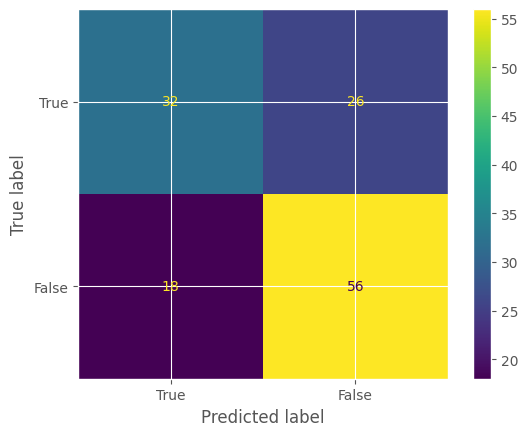

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix_test, display_labels=[True, False])
disp.plot()

accuracy_score(y_test,ypred)

These error rates are within a few percent of the labs values. Remember they may be using a different splitting criteria (above I stopped splitting when 20 samples were left) and the train test splits will not be the same.

## Notes about Pruning

Pruning for a classification Tree involves selecting a set of subtrees as a function of a penalization factor $\alpha $ according to the equation $\sum_{m=1}^{|T|}\sum_{i: x_i \in R_m}(y_i-\hat{y})^2+\alpha|T|$ and then using CV to find the optimal subtree. Sklearn does not provide any methods in their tree class to accomplish pruning. To implement this, we would need to develop a way to prune the returned tree object from sklearn. Since, pruned trees are not as competitive, in terms of predictive accuracy, with other models we will move on. I hope to come back to this and add this functionality to sklearn. It appears to be the first time in the ISLR book that we have hit a method where statsmodels or sklearn can not accomplish the same task as R.

# Random Forests

0.6666666666666666

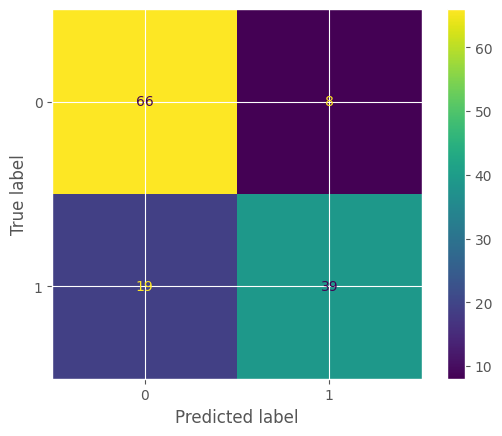

In [13]:
from sklearn.ensemble import RandomForestClassifier

# To build a random forest simply set the max features to be the sqrt of the number of features
forest = RandomForestClassifier(n_estimators=500, max_features=6, bootstrap=True, 
                               oob_score=True, random_state=0 )

#forest_est = forest.fit(X_train, y_train)
forest_est = forest.fit(X_train, np.ravel(y_train, order='c'))

y_pred = forest_est.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();
accuracy_score(y_test,ypred)

Price               0.275675
Age                 0.129963
CompPrice           0.123262
Advertising         0.122190
Income              0.096013
Population          0.076569
ShelveLoc_Good      0.071238
Education           0.052632
ShelveLoc_Medium    0.030224
US_Yes              0.013237
Urban_Yes           0.008999
dtype: float64

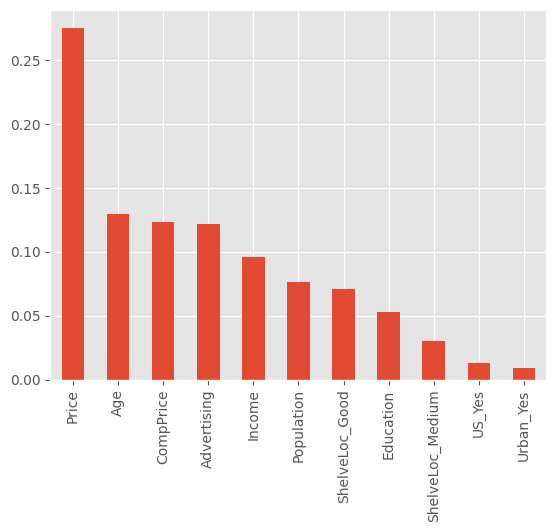

In [14]:
import seaborn as sns

# Examine the feature importances
feature_importances = pd.Series(forest_est.feature_importances_, index=predictors).sort_values(ascending=False)
feature_importances.plot.bar();

feature_importances